In [43]:
import torch
import numpy as np

from ldm.models.autoencoder import AutoencoderKL, AutoencoderKLWithJePA

import matplotlib.pyplot as plt

In [4]:
def load_config(config_path):
    import yaml
    with open(config_path, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

In [50]:
# get config
model_config = load_config('configs/autoencoder/autoencoder_kl_16x16x16.yaml')['model']['params']
model_config['ckpt_path'] = 'models/first_stage_models/kl-f16/model.ckpt'

# get model
model1 = AutoencoderKL(**model_config)
model1.eval()

making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Restored from models/first_stage_models/kl-f16/model.ckpt


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [27]:
from PIL import Image
import albumentations
import cv2

def process_image(image, size=256):
    # crop image to square
    # resize image to size
    # normalize image to [-1, 1]
    image = np.array(image).astype(np.uint8)
    min_side_len = min(image.shape[:2])
    cropper = albumentations.CenterCrop(
        height=min_side_len, width=min_side_len
    )
    image_rescaler = albumentations.SmallestMaxSize(
        max_size=size, interpolation=cv2.INTER_AREA
    )
    image = cropper(image=image)['image']
    image = image_rescaler(image=image)['image']
    image = (image / 127.5 - 1.0).astype(np.float32)
    image = torch.tensor(image[np.newaxis, ...])
    batch = {'image':  image}
    return batch


In [28]:
# get image
data_dir = "/usr1/vishwaja/pgm/datasets/ILSVRC2012_validation"

with open(f"{data_dir}/filelist.txt") as f:
    lines = f.readlines()


In [38]:
import matplotlib.pyplot as plt

def plot_image(image):
    inp1 = (image + 1) * 127.5
    plt.imshow(inp1[0].permute(1, 2, 0).detach().numpy().astype(np.uint8))
    plt.show()


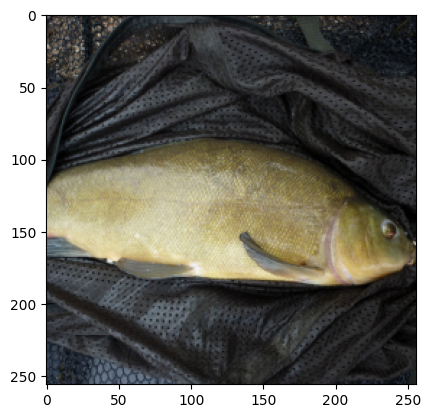

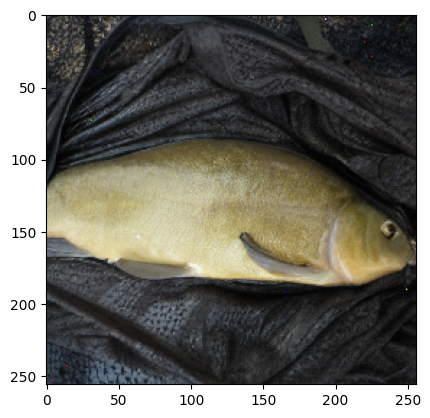

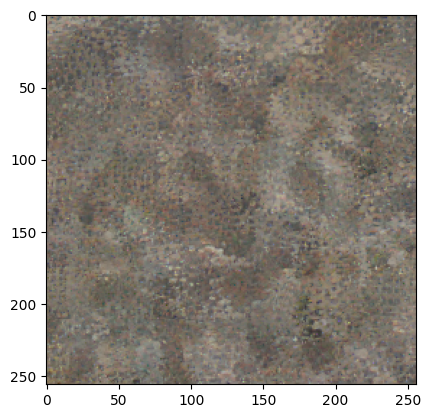

In [56]:
line = lines[16]
image_path = f"{data_dir}/data/{line.split()[0]}"

image = Image.open(image_path)
batch = process_image(image, 256)
log = model1.log_images(batch)
plot_image(log['inputs'])
plot_image(log['reconstructions'])
plot_image(log['samples'])

In [53]:
# test with JEPA model

model_config = load_config('configs/autoencoder/autoencoder_kl_16x16x1280.yaml')['model']['params']
model_config['ckpt_path'] = 'logs/2024-04-06T20-05-45_autoencoder_kl_16x16x1280/checkpoints/last.ckpt'

# get model
model = AutoencoderKLWithJePA(**model_config)
model.eval()

Working with z of shape (1, 64, 16, 16) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
Restored from logs/2024-04-06T20-05-45_autoencoder_kl_16x16x1280/checkpoints/last.ckpt


AutoencoderKLWithJePA(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((1280,), eps=1e-06, ele

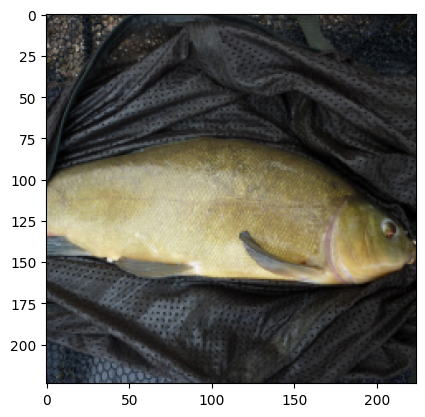

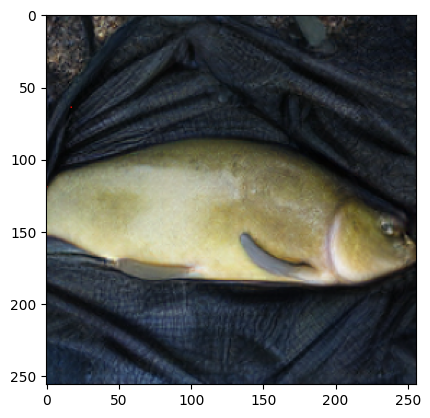

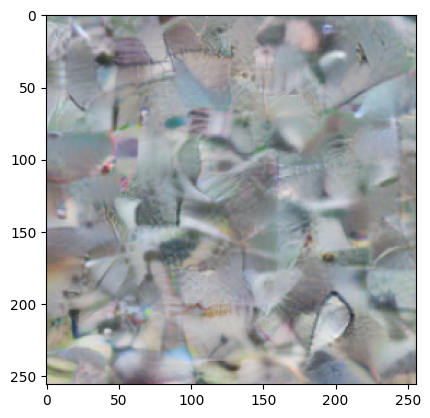

In [55]:
line = lines[16]
image_path = f"{data_dir}/data/{line.split()[0]}"
image = Image.open(image_path)
batch = process_image(image, 224)
log = model.log_images(batch)
plot_image(log['inputs'])
plot_image(log['reconstructions'])
plot_image(log['samples'])